<a href="https://colab.research.google.com/github/arshiakoul/CAC-anemia-detection-app/blob/main/CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Eyes Defy Anemia Dataset CNN**




In [ ]:
import pandas as pd
import numpy as np

from google.colab import files
uploaded = files.upload()

Saving archive (1).zip to archive (1).zip


In [ ]:

import os
import zipfile
import io
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab import files

In [ ]:
zip_ref = zipfile.ZipFile(io.BytesIO(uploaded['archive (1).zip']), 'r')
zip_ref.extractall('/content/anemia_dataset')
zip_ref.close()

KeyboardInterrupt: 

In [ ]:
os.listdir('/content/anemia_dataset')

['dataset anemia']

In [ ]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
italy_df = pd.read_excel('/content/anemia_dataset/dataset anemia/Italy/Italy.xlsx', engine='openpyxl')
india_df = pd.read_excel('/content/anemia_dataset/dataset anemia/India/India.xlsx', engine='openpyxl')

In [ ]:
italy_df['country'] = 'Italy'
india_df['country'] = 'India'

df = pd.concat([italy_df, india_df], ignore_index=True)

In [ ]:
print(df.head())
print("\nColumns:", df.columns)

   Number   Hgb Gender  Age                               Note  Unnamed: 5  \
0       1   9.3      F   82  Forniceal conjunctiva not visible         NaN   
1       2  10.2      F   77       da segmentare la forniceale          NaN   
2       3  10.7      F   52       da segmentare la forniceale          NaN   
3       4  11.7      F   73       da segmentare la forniceale          NaN   
4       5  11.6      F   74       da segmentare la forniceale          NaN   

  Unnamed: 6 Unnamed: 7             Unnamed: 8 country  
0        NaN        NaN                    NaN   Italy  
1        NaN        NaN  Segmentato da Michele   Italy  
2        NaN        NaN  Segmentato da Michele   Italy  
3        NaN        NaN  Segmentato da Michele   Italy  
4        NaN        NaN  Segmentato da Michele   Italy  

Columns: Index(['Number', 'Hgb', 'Gender', 'Age', 'Note', 'Unnamed: 5', 'Unnamed: 6',
       'Unnamed: 7', 'Unnamed: 8', 'country'],
      dtype='object')


In [ ]:
df['Hgb'] = pd.to_numeric(df['Hgb'], errors='coerce')

df = df.dropna(subset=['Hgb'])

threshold = 12.0
df['label'] = np.where(df['Hgb'] < threshold, 'anemic', 'non_anemic')

print(df[['Number', 'Hgb', 'label', 'country']].head())
print("\nData type of Hgb:", df['Hgb'].dtype)


   Number   Hgb   label country
0       1   9.3  anemic   Italy
1       2  10.2  anemic   Italy
2       3  10.7  anemic   Italy
3       4  11.7  anemic   Italy
4       5  11.6  anemic   Italy

Data type of Hgb: float64


In [ ]:
image_data = []

base_path = '/content/anemia_dataset/dataset anemia'
for country in ['India', 'Italy']:
    country_path = os.path.join(base_path, country)
    country_df = df[df['country'] == country]
    for folder_name in os.listdir(country_path):
        folder_path = os.path.join(country_path, folder_name)
        if os.path.isdir(folder_path):
            try:
                patient_num = int(folder_name)
            except:
                continue
            row = country_df[country_df['Number'] == patient_num]
            if not row.empty:
                label = row['label'].values[0]
                for img_file in os.listdir(folder_path):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        image_data.append({
                            'path': os.path.join(folder_path, img_file),
                            'label': label
                        })

image_df = pd.DataFrame(image_data)
print("Total images:", len(image_df))
print(image_df.head())


Total images: 800
                                                path       label
0  /content/anemia_dataset/dataset anemia/India/3...  non_anemic
1  /content/anemia_dataset/dataset anemia/India/3...  non_anemic
2  /content/anemia_dataset/dataset anemia/India/3...  non_anemic
3  /content/anemia_dataset/dataset anemia/India/3...  non_anemic
4  /content/anemia_dataset/dataset anemia/India/3...      anemic


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input


train_df, val_df = train_test_split(
    image_df,
    test_size=0.2,
    stratify=image_df['label'],
    random_state=42
)

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)

val_data = val_gen.flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)

Found 640 validated image filenames belonging to 2 classes.
Found 160 validated image filenames belonging to 2 classes.


In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,776,577 (94.52 MB)

 Trainable params: 1,184,769 (4.52 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [ ]:
from PIL import Image

bad_images = []

for path in image_df['path']:
    try:
        with Image.open(path) as img:
            img.verify()
    except Exception as e:
        bad_images.append(path)

print(f"Bad images: {len(bad_images)}")
if bad_images:
    print(bad_images[:10])


Bad images: 169
['/content/anemia_dataset/dataset anemia/India/31/20200213_152924_forniceal_palpebral.png', '/content/anemia_dataset/dataset anemia/India/31/20200213_152924_palpebral.png', '/content/anemia_dataset/dataset anemia/India/31/20200213_152924_forniceal.png', '/content/anemia_dataset/dataset anemia/India/19/20200211_140525_forniceal_palpebral.png', '/content/anemia_dataset/dataset anemia/India/19/20200211_140525_forniceal.png', '/content/anemia_dataset/dataset anemia/India/19/20200211_140525_palpebral.png', '/content/anemia_dataset/dataset anemia/India/13/20200203_190841_forniceal.png', '/content/anemia_dataset/dataset anemia/India/13/20200203_190841_forniceal_palpebral.png', '/content/anemia_dataset/dataset anemia/India/13/20200203_190841_palpebral.png', '/content/anemia_dataset/dataset anemia/India/16/20200204_155221_palpebral.png']


In [ ]:
image_df = image_df[~image_df['path'].isin(bad_images)]
print("Cleaned dataset size:", len(image_df))

Cleaned dataset size: 631


In [ ]:
train_df, val_df = train_test_split(
    image_df,
    test_size=0.2,
    stratify=image_df['label'],
    random_state=42
)

train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)

val_data = val_gen.flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)

Found 504 validated image filenames belonging to 2 classes.
Found 127 validated image filenames belonging to 2 classes.


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(train_df['label'])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_df['label'])
class_weights = dict(zip(classes, weights))

print("Class weights:", class_weights)


Class weights: {'anemic': np.float64(1.2857142857142858), 'non_anemic': np.float64(0.8181818181818182)}


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_anemia_model.keras', save_best_only=True, monitor='val_loss')

history_head = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,
    callbacks=[early_stop, checkpoint],
    class_weight=class_weights
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 165s 5s/step - accuracy: 0.5704 - loss: 0.8382 - val_accuracy: 0.6220 - val_loss: 0.7700
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 145s 5s/step - accuracy: 0.5498 - loss: 0.8152 - val_accuracy: 0.6378 - val_loss: 0.6460
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - accuracy: 0.6857 - loss: 0.6925 - val_accuracy: 0.6378 - val_loss: 0.6483
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 146s 5s/step - accuracy: 0.6148 - loss: 0.7663 - val_accuracy: 0.6929 - val_loss: 0.5910
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.6355 - loss: 0.7042 - val_accuracy: 0.7165 - val_loss: 0.5847


In [ ]:
for layer in base_model.layers[-50:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

fine_tune_epochs = 15
total_epochs = 5 + fine_tune_epochs

history_finetune = model.fit(
    train_data,
    validation_data=val_data,
    epochs=total_epochs,
    initial_epoch=history_head.epoch[-1],
    callbacks=[early_stop, checkpoint],
    class_weight=class_weights
)

Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 258s 7s/step - accuracy: 0.7059 - loss: 0.6007 - val_accuracy: 0.6772 - val_loss: 0.6012
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 226s 7s/step - accuracy: 0.7105 - loss: 0.6128 - val_accuracy: 0.6850 - val_loss: 0.5883
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 232s 7s/step - accuracy: 0.6498 - loss: 0.6509 - val_accuracy: 0.7087 - val_loss: 0.5745
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 235s 7s/step - accuracy: 0.6404 - loss: 0.7092 - val_accuracy: 0.7480 - val_loss: 0.5624
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 228s 7s/step - accuracy: 0.7126 - loss: 0.5701 - val_accuracy: 0.7165 - val_loss: 0.6006
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 225s 7s/step - accuracy: 0.7262 - loss: 0.5441 - val_accuracy: 0.7165 - val_loss: 0.5963
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 263s 7s/step - accuracy: 0.7201 - loss: 0.6294 - val_accuracy: 0.7244 - val_loss: 0.5723
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 221s 7s/step - accuracy: 0.6982 - loss: 0.6116 - val_accuracy: 0.7323 

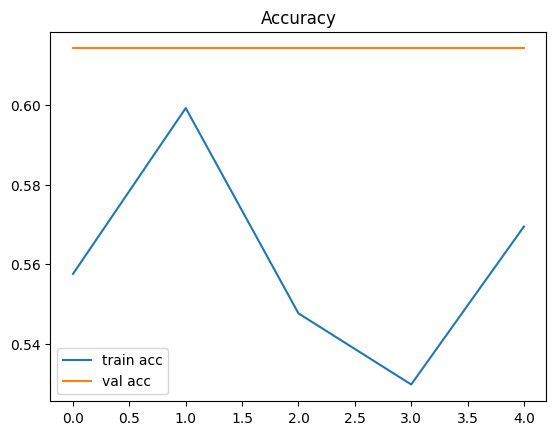

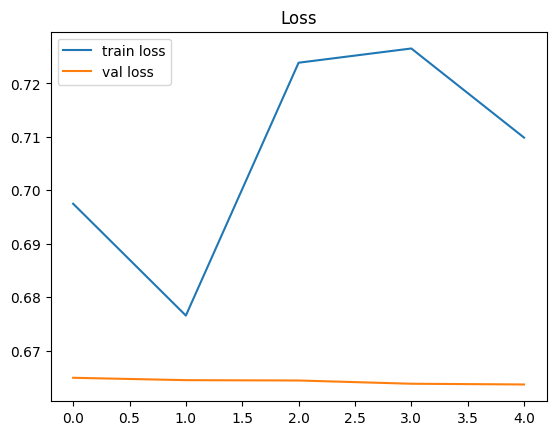

8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.7059 - loss: 0.6231
Validation Accuracy: 0.748


In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.show()

val_loss, val_acc = model.evaluate(val_data)
print(f"Validation Accuracy: {val_acc:.3f}")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true = val_data.classes

y_pred_prob = model.predict(val_data)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

target_names = ['non_anemic', 'anemic']
print(classification_report(y_true, y_pred, target_names=target_names))

8/8 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step
Confusion Matrix:
 [[17 32]
 [18 60]]
              precision    recall  f1-score   support

  non_anemic       0.49      0.35      0.40        49
      anemic       0.65      0.77      0.71        78

    accuracy                           0.61       127
   macro avg       0.57      0.56      0.56       127
weighted avg       0.59      0.61      0.59       127



In [ ]:
y_true = val_data.classes

y_pred_prob = model.predict(val_data)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()


from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)


target_names = ['non_anemic', 'anemic']
print(classification_report(y_true, y_pred, target_names=target_names))

8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step
Confusion Matrix:
 [[14 35]
 [21 57]]
              precision    recall  f1-score   support

  non_anemic       0.40      0.29      0.33        49
      anemic       0.62      0.73      0.67        78

    accuracy                           0.56       127
   macro avg       0.51      0.51      0.50       127
weighted avg       0.53      0.56      0.54       127



In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_data = val_gen.flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)


In [ ]:
model.save('anemia_model.keras')

In [ ]:
from google.colab import files
files.download('/content/anemia_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip uninstall -y tensorflow
!pip install tensorflow==2.19

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.0/645.0 MB 1.3 MB/s eta 0:00:00


# **CNN**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, x):
        return

In [ ]:
def evaluate(model, loader, device):
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    accuracy = val_correct / val_total
    return accuracy

def train_model(model, train_loader, test_loader, num_epochs=10, learning_rate=0.001, device='cuda'):
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        val_acc = evaluate(model, test_loader, device)

        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Acc: {val_acc:.4f}")

In [ ]:
cnn = SimpleCNN()
train_model(cnn, train_loader, test_loader)

In [ ]:
transform = transforms.ToTensor()

train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)